<a href="https://colab.research.google.com/github/amontoison/Workshop-GERAD/blob/main/gpu_kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel computing and GPU programming with Julia
## Part IV: GPU Kernels with KernelAbstractions.jl
Alexis Montoison

In [1]:
import Pkg
Pkg.activate("@colab")
Pkg.add([
    "CUDA",
    "KernelAbstractions",
    "Atomix",
    "AcceleratedKernels",
    "BenchmarkTools",
    "Adapt",
    "NVTX",
    "ImageShow",
])

  Activating new project at `/content/@colab`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ImageShow ────────── v0.3.8
   Installed BenchmarkTools ───── v1.6.0
   Installed AcceleratedKernels ─ v0.4.3
    Updating `/content/@colab/Project.toml`
  [6a4ca0a5] + AcceleratedKernels v0.4.3
  [79e6a3ab] + Adapt v4.3.0
  [a9b6321e] + Atomix v1.1.2
  [6e4b80f9] + BenchmarkTools v1.6.0
  [052768ef] + CUDA v5.8.3
  [4e3cecfd] + ImageShow v0.3.8
  [63c18a36] + KernelAbstractions v0.9.38
  [5da4648a] + NVTX v1.0.1
    Updating `/content/@colab/Manifest.toml`
  [621f4979] + AbstractFFTs v1.5.0
  [6a4ca0a5] + AcceleratedKernels v0.4.3
  [79e6a3ab] + Adapt v4.3.0
  [dce04be8] + ArgCheck v2.5.0
  [a9b6321e] + Atomix v1.1.2
  [ab4f0b2a] + BFloat16s v0.5.1
  [6e4b80f9] + BenchmarkTools v1.6.0
  [fa961155] + CEnum v0.5.0
  [052768ef] + CUDA v5.8.3
  [1af6417a] + CUDA_Runtime_Discovery v1.0.0
  [35d6a980] + ColorSchemes v3.31.0
  [3da002f7] + Co

In [ ]:
versioninfo()

Julia Version 1.10.9
Commit 5595d20a287 (2025-03-10 12:51 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, skylake-avx512)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/lib64-nvidia
  JULIA_NUM_THREADS = auto


In [ ]:
using CUDA, KernelAbstractions, Adapt

### Different layers of abstraction

#### Vendor-specific

In [ ]:
function saxpy!(a,X,Y)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if i <= length(Y)
        @inbounds Y[i] = a * X[i] + Y[i]
    end
    return nothing
end

@cuda threads=32 blocks=cld(length(Y), 32) saxpy!(a, X, Y)

#### KernelAbstractions

In [ ]:
using KernelAbstractions
using CUDA

@kernel function saxpy!(a, @Const(X), Y)
    I = @index(Global)
    @inbounds Y[I] = a * X[I] + Y[I]
end

saxpy!(CUDABackend())(a, X, Y, ndrange=length(Y))

#### Array abstractions

In [ ]:
Y .= a .* X .+ Y

#### How to use KernelAbstractions

- Use `@kernel function mykernel(args...) end` to write a GPU-style program
- Instantiate kernel for a backend `kernel = mykernel(backend)`
- Backends come from Vendor specific libraries
- `KA.allocate(backend, ...)` to obtain memory
- Launch kernel `kernel(args..., ndrange=...)` while specifying the grid to execute over.

In [ ]:
function vadd(a, b, c)
    for i in eachindex(c)
        c[i] = a[i] + b[i]
    end
end

a = rand(N)
b = rand(N)
c = similar(a)

vadd(a, b, c)

In [ ]:
import KernelAbstractions as KA

@kernel function vadd(a, b, c)
    i = @index(Global)
    c[i] = a[i] + b[i]
end

backend = CUDABackend()
a = KA.allocate(backend, Float32, N)
b = KA.allocate(backend, Float32, N)
c = similar(a)

vadd_kernel = vadd(backend)
vadd_kernel(a, b, c; ndrange=size(c))

#### Asynchronous operations

GPU operations are asynchronous with regards to the host! They are **ordered** with respect to each other, but special care must be taken when using Julia's task based programming together with GPU programming.

The JuliaGPU ecosystem **synchronizes** the GPU on access, so when you move data from and to the GPU we wait for all the kernels to finish!

When benchmarking you need to synchronize the device!

```julia
@benchmark begin
    vadd_kernel(a, b, c; ndrange=size(c))
    KA.synchronize(backend)
end
```

Otherwise you are only measuring the **launch** of the kernel.

### High-level array based programming

Julia and GPUArrays.jl provide support for an efficient GPU programming environment build around array abstractions and higher-order functions.

- **Vocabulary of operations**: `map`, `broadcast`, `scan`, `reduce`, ...
  Map naturally onto GPU execution models
- **Compiled to efficient code**: multiple dispatch, specialization
  Write generic, reusable applications
- BLAS (matrix-multiply, ...), and other libraries like FFT

Array types -- **where** memory resides and **how** code is executed.
Note that data movement is explicit.

|  |  |
| --- | --- |
|  `A = Matrix{Float64}(undef, 64, 32)`   | CPU   |
|  `A = CuMatrix{Float64}(undef, 64, 32)`   | Nvidia GPU   |
|  `A = ROCMatrix{Float64}(undef, 64, 32)`   | AMD GPU   |

### What makes an application portable?

1. Can I **run** it on a different compute architecture
    1. Different CPU architectures
    2. We live in a mult GPU vendor world
2. Does it **compute** the same thing?
    1. Can I develop on one platform and move to another later?
3. Does it achieve the same **performance**?
4. Can I take advantage of platform **specific** capabilities?

#### Adapt.jl

[Adapt.jl](https://github.com/JuliaGPU/Adapt.jl) is a lightweight dependency that you can use to convert complex structures from CPU to GPU.

```julia
using Adapt
adapt(CuArray, ::Adjoint{Array})::Adjoint{CuArray}
```

```julia
struct Model{T<:Number, AT<:AbstractArray{T}}
   data::AT
end

Adapt.adapt_structure(to, x::Model) = Model(adapt(to, x.data))

cpu = Model(rand(64, 64));
using CUDA

gpu = adapt(CuArray, cpu)
Model{Float64, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}(...)
```

## A first GPU kernel

In [ ]:
function copy_cpu!(A, B)
  for I in 1:length(A)
    @inbounds A[I] = B[I]
  end
end

copy_cpu! (generic function with 1 method)

In [ ]:
@kernel function copy_kernel!(A, B)
  I = @index(Global)
  @inbounds A[I] = B[I]
end

copy_kernel! (generic function with 4 methods)

In [ ]:
function copy_ka!(A, B)
  backend = get_backend(A)
  @assert size(A) == size(B)
  @assert get_backend(B) == backend

  kernel = copy_kernel!(backend)
  kernel(A, B, ndrange = length(A))
  return
end

copy_ka! (generic function with 1 method)

In [ ]:
using CUDA: i32

In [ ]:
function copy_kernel_cuda!(A, B)
  I = (blockIdx().x-1i32) * blockDim().x + threadIdx().x
  if I <= length(A)
      @inbounds A[I] = B[I]
  end
  return nothing
end

copy_kernel_cuda! (generic function with 1 method)

In [ ]:
function copy_cuda!(A, B)
  kernel = @cuda launch=false copy_kernel_cuda!(A, B)
  config = launch_configuration(kernel.fun)
  threads = min(length(A), config.threads)
  blocks = cld(length(A), threads)

  kernel(A, B; threads, blocks)
end

copy_cuda! (generic function with 1 method)

In [ ]:
B = rand(64_000);

In [ ]:
let
  A = similar(B)
  copy_cpu!(A, B)
  @assert A == B
end

Julia GPU ecosystem follows the motto: Compute follows Data

So let's move our data to the GPU!

In [ ]:
d_B = adapt(CuArray, B);

In [ ]:
typeof(d_B)

CuArray{Float64, 1, CUDA.DeviceMemory}

In [ ]:
let
  d_A = similar(d_B)
  copy_cuda!(d_A, d_B)
  @assert d_A == d_B
end

Note that Julia GPU Ecosystem, synchronizes the GPU on access. So we are launchign two GPU kernels here, first the copy, then the comparision and they are both executing asynchronously, but ordered with respect to each other.

We then "wait" for the result of the comparision.

In [ ]:
using BenchmarkTools

In [ ]:
@benchmark copy_cuda!(d_A, $d_B) setup=(d_A = similar(d_B))

BenchmarkTools.Trial: 10000 samples with 6 evaluations per sample.
 Range (min … max):  5.686 μs …  16.612 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.044 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.248 μs ± 780.293 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▇████▇▅▄▃▁▁▁ ▁  ▁▂▂▂▁▁▁▁                                   ▂
  ████████████████████████████▇▆▆▆▅▆▆▅▆▆▅▄▅▅▅▆▅▄▃▅▅▅▄▅▅▅▇▅▆▆▆ █
  5.69 μs      Histogram: log(frequency) by time      10.2 μs <

 Memory estimate: 720 bytes, allocs estimate: 28.

In [ ]:
CUDA.@profile let
  d_A = similar(d_B)
  for _ in 1:10
    copy_cuda!(d_A, d_B)
  end
end

Profiler ran for 270.84 µs, capturing 261 events.

Host-side activity: calling CUDA APIs took 119.92 µs (44.28% of the trace)
┌──────────┬────────────┬───────┬─────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                   │ Name                    │
├──────────┼────────────┼───────┼─────────────────────────────────────┼─────────────────────────┤
│   27.64% │   74.86 µs │    10 │   7.49 µs ± 9.96   (  3.58 ‥ 35.76) │ cuLaunchKernel          │
│    4.40% │   11.92 µs │     1 │                                     │ cuMemAllocFromPoolAsync │
└──────────┴────────────┴───────┴─────────────────────────────────────┴─────────────────────────┘

Device-side activity: GPU was busy for 56.03 µs (20.69% of the trace)
┌──────────┬────────────┬───────┬────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution             

So there seems to be a discrepancy between the measurement of `@benchmark` and `CUDA.@profile`, `@benchmark` seems to vastly over-estimate the performance of the GPU code. To remedy this we need to include a synchronization operation with benchmarking.

In [ ]:
@benchmark CUDA.@sync(copy_cuda!(d_A, $d_B)) setup=(d_A = similar(d_B))

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  19.916 μs … 104.479 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     21.002 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.472 μs ±   2.380 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▃▅▇███▆▅▄▃▂▁                                                ▂
  ███████████████▇▇▆▆▆▇▆▇▇▆▆▆▆▆▅▅▆▆▆▆▆▆▄▆▇▆▇▆▅▇▅▅▅▆▅▆▆▆▅▆▆▆▆▆▆ █
  19.9 μs       Histogram: log(frequency) by time      31.4 μs <

 Memory estimate: 720 bytes, allocs estimate: 28.

With KernelAbstractions we can now write code that is portable and can be used both for data that resides on the CPU as well as the GPU, therefore implementing the "Compute follows Data" paradigm.

In [ ]:
let
  A = similar(B)
  copy_ka!(A, B)
  @assert A == B
end

In [ ]:
let
  d_A = similar(d_B)
  copy_ka!(d_A, d_B)
  @assert d_A == d_B
end

In [ ]:
@benchmark copy_ka!(A, $B) setup=(A = similar(B))

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  108.141 μs …   7.116 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     126.832 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   186.821 μs ± 128.714 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆█▇▆▄▂▁    ▁▁▂▂▄▅▆▄▃▂▁                ▁▁               ▁▃▄▄▃▁ ▂
  ████████▇▇████████████▆▅▆▆▆▇▇█▆▆▆▅▅▅▇█████▇▆▅▄▄▂▃▂▃▄▄▇▇██████ █
  108 μs        Histogram: log(frequency) by time        435 μs <

 Memory estimate: 1.83 KiB, allocs estimate: 33.

In [ ]:
@benchmark CUDA.@sync(copy_ka!(d_A, $d_B)) setup=(d_A = similar(d_B))

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  24.232 μs …  8.109 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     25.365 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   27.597 μs ± 84.574 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▇█▇▆▅▃▂▁                                                   ▂
  ███████████▆█▇▇▇▇▇▇▇▇▇▆▇▇▇▆▇▆▆▅▅▆▅▅▅▆▆▆▇▇█▇▇▇▇▇▇▆▃▅▄▅▃▆▅▅▅▅ █
  24.2 μs      Histogram: log(frequency) by time      46.6 μs <

 Memory estimate: 1.62 KiB, allocs estimate: 60.

In [ ]:
CUDA.@profile let
  d_A = similar(d_B)
  for _ in 1:10
    copy_ka!(d_A, d_B)
  end
end

Profiler ran for 333.31 µs, capturing 261 events.

Host-side activity: calling CUDA APIs took 105.62 µs (31.69% of the trace)
┌──────────┬────────────┬───────┬─────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                   │ Name                    │
├──────────┼────────────┼───────┼─────────────────────────────────────┼─────────────────────────┤
│   21.03% │    70.1 µs │    10 │   7.01 µs ± 7.78   (  3.81 ‥ 29.09) │ cuLaunchKernel          │
│    1.50% │    5.01 µs │     1 │                                     │ cuMemAllocFromPoolAsync │
└──────────┴────────────┴───────┴─────────────────────────────────────┴─────────────────────────┘

Device-side activity: GPU was busy for 59.13 µs (17.74% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

We can see that KernelAbstractions is a bit slower than pure CUDA, and that is partially expected due to some convenience functionality.

In [ ]:
@kernel unsafe_indices=true function copy_kernel_faster!(A, B)
  N = @uniform prod(@groupsize())
  I = (@index(Group, Linear)-1i32) * N + @index(Local, Linear)
  if I <= length(A)
    @inbounds A[I] = B[I]
  end
end

copy_kernel_faster! (generic function with 4 methods)

In [ ]:
CUDA.@profile let
  d_A = similar(d_B)
  for _ in 1:10
    copy_kernel_faster!(CUDABackend())(d_A, d_B, ndrange=length(d_A))
  end
end

Profiler ran for 204.54 ms, capturing 281 events.

Host-side activity: calling CUDA APIs took 316.38 µs (0.15% of the trace)
┌──────────┬────────────┬───────┬─────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                   │ Name                    │
├──────────┼────────────┼───────┼─────────────────────────────────────┼─────────────────────────┤
│    0.05% │  105.38 µs │     1 │                                     │ cuModuleLoadDataEx      │
│    0.04% │   88.21 µs │    10 │   8.82 µs ± 12.46  (  3.81 ‥ 44.11) │ cuLaunchKernel          │
│    0.02% │   46.49 µs │     1 │                                     │ cuModuleGetFunction     │
│    0.01% │   11.21 µs │     1 │                                     │ cuCtxSynchronize        │
│    0.00% │    5.48 µs │     1 │                                     │ cuMemAllocFromPoolAsync │
└──────────┴────────────┴───────┴─────────────────────────────────────┴────────────────────

## A more compilcated kernel -- transpose

In [ ]:
const nreps = 3
const N = 2048
const T = Float32

const TILE_DIM = 32
const BLOCK_ROWS = 8

8

### Naive kernels

In [ ]:
@kernel function simple_copy_kernel!(output, @Const(input))
    I, J = @index(Global, NTuple)
    @inbounds output[I, J] = input[I, J]
end

simple_copy_kernel! (generic function with 4 methods)

In [ ]:
@kernel function simple_transpose_kernel!(output, @Const(input))
    I, J = @index(Global, NTuple)
    @inbounds output[J, I] = input[I, J]
end

simple_transpose_kernel! (generic function with 4 methods)

### Using localmemory

In [ ]:
@kernel unsafe_indices = true function lmem_copy_kernel!(
        output, @Const(input),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    I, J = @index(Global, NTuple)
    i, j = @index(Local, NTuple)

    N = @uniform @groupsize()[1]
    M = @uniform @groupsize()[2]

    # +1 to avoid bank conflicts on shared memory
    tile = @localmem eltype(output) (N + BANK, M)

    @inbounds tile[i, j] = input[I, J]

    @synchronize

    @inbounds output[I, J] = tile[i, j]
end

lmem_copy_kernel! (generic function with 4 methods)

In [ ]:
@kernel unsafe_indices = true function lmem_transpose_kernel!(
        output, @Const(input),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    gi, gj = @index(Group, NTuple)
    i, j = @index(Local, NTuple)

    N = @uniform @groupsize()[1]
    M = @uniform @groupsize()[2]

    # +1 to avoid bank conflicts on shared memory
    tile = @localmem eltype(output) (N + BANK, M)

    # Manually calculate global indexes
    # Later on we need to pivot the group index
    I = (gi - 1) * N + i
    J = (gj - 1) * M + j

    @inbounds tile[i, j] = input[I, J]

    @synchronize

    # Pivot the group index
    I = (gj - 1) * M + i
    J = (gi - 1) * N + j

    @inbounds output[I, J] = tile[j, i]
end

lmem_transpose_kernel! (generic function with 4 methods)

### Local Memory + process multiple elements per lane

In [ ]:
using KernelAbstractions.Extras: @unroll

In [ ]:
@kernel unsafe_indices=true function coalesced_copy_kernel!(
        output, @Const(input),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    gi, gj = @index(Group, NTuple)
    i, j = @index(Local, NTuple)

    TILE_DIM = @uniform @groupsize()[1]
    BLOCK_ROWS = @uniform @groupsize()[2]

    # +1 to avoid bank conflicts on shared memory
    tile = @localmem eltype(output) (TILE_DIM + BANK, TILE_DIM)

    # Can't use @index(Global), because we use a smaller ndrange
    I = (gi - 1) * TILE_DIM + i
    J = (gj - 1) * TILE_DIM + j

    @unroll for k in 0:BLOCK_ROWS:(TILE_DIM - 1)
        @inbounds tile[i, j + k] = input[I, J + k]
    end

    @synchronize

    @unroll for k in 0:BLOCK_ROWS:(TILE_DIM - 1)
        @inbounds output[I, J + k] = tile[i, j + k]
    end
end

coalesced_copy_kernel! (generic function with 4 methods)

In [ ]:
@kernel unsafe_indices = true function coalesced_transpose_kernel!(
        output, @Const(input),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    gi, gj = @index(Group, NTuple)
    i, j = @index(Local, NTuple)

    TILE_DIM = @uniform @groupsize()[1]
    BLOCK_ROWS = @uniform @groupsize()[2]

    # +1 to avoid bank conflicts on shared memory
    tile = @localmem eltype(output) (TILE_DIM + BANK, TILE_DIM)

    # Can't use @index(Global), because we use a smaller ndrange
    I = (gi - 1) * TILE_DIM + i
    J = (gj - 1) * TILE_DIM + j

    @unroll for k in 0:BLOCK_ROWS:(TILE_DIM - 1)
        @inbounds tile[i, j + k] = input[I, J + k]
    end

    @synchronize

    # Transpose block offsets
    I = (gj - 1) * TILE_DIM + i
    J = (gi - 1) * TILE_DIM + j

    @unroll for k in 0:BLOCK_ROWS:(TILE_DIM - 1)
        @inbounds output[I, J + k] = tile[j + k, i]
    end
end

coalesced_transpose_kernel! (generic function with 4 methods)

### Benchmark harness

In [ ]:
using NVTX, Random

In [ ]:
backend = CUDABackend()

CUDABackend(false, false)

In [ ]:
CUDA.@profile for block_dims in ((TILE_DIM, TILE_DIM), (TILE_DIM * TILE_DIM, 1), (1, TILE_DIM * TILE_DIM))
    for (name, kernel) in (
            ("copy", simple_copy_kernel!(backend, block_dims)),
            ("transpose", simple_transpose_kernel!(backend, block_dims)),
        )
        NVTX.@range "Simple $name $block_dims" let
            input = rand!(allocate(backend, T, N, N))
            output = similar(input)

            # compile kernel
            kernel(output, input, ndrange = size(output))
            for rep in 1:nreps
                kernel(output, input, ndrange = size(output))
            end
            KernelAbstractions.synchronize(backend)
        end
    end
end

Profiler ran for 17.26 ms, capturing 5372 events.

Host-side activity: calling CUDA APIs took 4.69 ms (27.17% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                     │ Name                    │
├──────────┼────────────┼───────┼───────────────────────────────────────┼─────────────────────────┤
│   71.43% │   12.33 ms │     6 │   2.05 ms ± 1.29   (  0.64 ‥ 3.98)    │ cuStreamSynchronize     │
│    1.05% │  180.72 µs │    24 │   7.53 µs ± 3.92   (  4.29 ‥ 19.31)   │ cuLaunchKernel          │
│    0.80% │  137.81 µs │     6 │  22.97 µs ± 5.96   ( 19.07 ‥ 34.81)   │ cudaLaunchKernel        │
│    0.54% │   93.94 µs │    12 │   7.83 µs ± 3.72   (  3.58 ‥ 13.59)   │ cuMemAllocFromPoolAsync │
│    0.04% │    7.39 µs │    12 │ 615.91 ns ± 448.45 (   0.0 ‥ 1192.09) │ cudaGetLastError        │
└──────────┴────────────┴───────┴───────────────────────────────────────┴───

In [ ]:
# Benchmark localmem
CUDA.@profile for (name, kernel) in (
        ("copy", lmem_copy_kernel!(backend, (TILE_DIM, TILE_DIM))),
        ("transpose", lmem_transpose_kernel!(backend, (TILE_DIM, TILE_DIM))),
    )
    for bank in (true, false)
        NVTX.@range "Localmem $name ($TILE_DIM, $TILE_DIM) bank=$bank" let
            input = rand!(allocate(backend, T, N, N))
            output = similar(input)

            # compile kernel
            kernel(output, input, Val(Int(bank)), ndrange = size(output))
            for rep in 1:nreps
                kernel(output, input, Val(Int(bank)), ndrange = size(output))
            end
            KernelAbstractions.synchronize(backend)
        end
    end
end

Profiler ran for 7.2 ms, capturing 3582 events.

Host-side activity: calling CUDA APIs took 1.67 ms (23.24% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                     │ Name                    │
├──────────┼────────────┼───────┼───────────────────────────────────────┼─────────────────────────┤
│   53.14% │    3.83 ms │     4 │ 956.89 µs ± 477.44 (709.06 ‥ 1672.98) │ cuStreamSynchronize     │
│    1.74% │  125.65 µs │    16 │   7.85 µs ± 3.47   (  4.77 ‥ 15.5)    │ cuLaunchKernel          │
│    1.36% │   97.75 µs │     4 │  24.44 µs ± 4.58   (  20.5 ‥ 30.76)   │ cudaLaunchKernel        │
│    0.92% │   66.04 µs │     8 │   8.26 µs ± 4.12   (  3.58 ‥ 15.02)   │ cuMemAllocFromPoolAsync │
│    0.07% │    5.25 µs │     8 │ 655.65 ns ± 594.34 (   0.0 ‥ 1430.51) │ cudaGetLastError        │
└──────────┴────────────┴───────┴───────────────────────────────────────┴─────

In [ ]:
# Benchmark localmem + multiple elements per lane
CUDA.@profile for (name, kernel) in (
        ("copy", coalesced_copy_kernel!(backend, (TILE_DIM, BLOCK_ROWS))),
        ("transpose", coalesced_transpose_kernel!(backend, (TILE_DIM, BLOCK_ROWS))),
    )
    for bank in (true, false)
        NVTX.@range "Localmem + multiple elements $name ($TILE_DIM, $BLOCK_ROWS) bank=$bank" let
            input = rand!(allocate(backend, T, N, N))
            output = similar(input)

            # We want a number of blocks equivalent to (TILE_DIM, TILE_DIM)
            # but our blocks are (TILE_DIM, BLOCK_ROWS) so we need to remove
            # a factor from the size of the array otherwise we get to many blocks
            block_factor = div(TILE_DIM, BLOCK_ROWS)
            ndrange = (N, div(N, block_factor))

            # compile kernel
            kernel(output, input, Val(Int(bank)), ndrange = ndrange)
            for rep in 1:nreps
                kernel(output, input, Val(Int(bank)), ndrange = ndrange)
            end
            KernelAbstractions.synchronize(backend)
        end
    end
end

Profiler ran for 4.65 ms, capturing 2934 events.

Host-side activity: calling CUDA APIs took 1.1 ms (23.57% of the trace)
┌──────────┬────────────┬───────┬──────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                    │ Name                    │
├──────────┼────────────┼───────┼──────────────────────────────────────┼─────────────────────────┤
│   23.73% │     1.1 ms │     4 │ 275.67 µs ± 545.62 (  2.62 ‥ 1094.1) │ cuStreamSynchronize     │
│    4.08% │  189.78 µs │    16 │  11.86 µs ± 5.74   (  5.01 ‥ 28.37)  │ cuLaunchKernel          │
│    1.81% │   83.92 µs │     4 │  20.98 µs ± 8.79   ( 15.74 ‥ 34.09)  │ cudaLaunchKernel        │
│    1.26% │   58.65 µs │     8 │   7.33 µs ± 4.05   (  3.34 ‥ 13.35)  │ cuMemAllocFromPoolAsync │
│    0.09% │    4.29 µs │     8 │ 536.44 ns ± 397.93 (   0.0 ‥ 953.67) │ cudaGetLastError        │
└──────────┴────────────┴───────┴──────────────────────────────────────┴──────────────

## Atomic operations

In [ ]:
@kernel function racy_kernel!(out, arr)
	i, j = @index(Global, NTuple)
	for k in 1:size(out, 1)
		out[k, i] += arr[i, j]
	end
end

racy_kernel! (generic function with 4 methods)

In [ ]:
using ImageShow

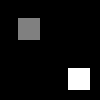

In [ ]:
img = zeros(Float32, (50, 50));
img[10:20, 10:20] .= 1;
img[35:45, 35:45] .= 2;
simshow(img)

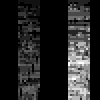

In [ ]:
out = KernelAbstractions.zeros(backend, Float32, size(img));
racy_kernel!(backend)(out, adapt(backend, img), ndrange=size(img))
simshow(Array(out))

In [ ]:
using Atomix: @atomic, @atomicswap, @atomicreplace

In [ ]:
@kernel function nonracy_kernel!(out, arr)
	i, j = @index(Global, NTuple)
	for k in 1:size(out, 1)
		@atomic out[k, i] += arr[i, j]
	end
end

nonracy_kernel! (generic function with 4 methods)

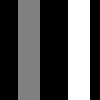

In [ ]:
out = KernelAbstractions.zeros(backend, Float32, size(img));
nonracy_kernel!(backend)(out, adapt(backend, img), ndrange=size(img))
simshow(Array(out))

## Matrix multiply

In [ ]:
@kernel function naive_matmul_kernel!(output, a, b)
    i, j = @index(Global, NTuple)

    # creating a temporary sum variable for matrix multiplication
    tmp_sum = zero(eltype(output))
    for k in 1:size(a)[2]
        tmp_sum += a[i, k] * b[k, j]
    end

    output[i, j] = tmp_sum
end

naive_matmul! (generic function with 1 method)

In [ ]:
# Creating a wrapper kernel for launching with error checks
function naive_matmul!(output, a, b)
    if size(a)[2] != size(b)[1]
        println("Matrix size mismatch!")
        return nothing
    end
    backend = KernelAbstractions.get_backend(a)
    kernel! = naive_matmul_kernel!(backend)
    kernel!(output, a, b, ndrange = size(output))
    return
end

In [ ]:
let
  a = rand!(allocate(backend, Float32, 256, 123))
  b = rand!(allocate(backend, Float32, 123, 45))
  output = KernelAbstractions.zeros(backend, Float32, 256, 45)

  naive_matmul!(output, a, b)

  @assert isapprox(output, a * b)
end

In [ ]:
@kernel unsafe_indices = true function coalesced_matmul_kernel!(
        output, @Const(A), @Const(B),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    gi, gj = @index(Group, NTuple)
    i, j = @index(Local, NTuple)

    TILE_DIM = @uniform @groupsize()[1]

    # +1 to avoid bank conflicts on shared memory
    tile1 = @localmem eltype(output) (TILE_DIM + BANK, TILE_DIM)
    tile2 = @localmem eltype(output) (TILE_DIM + BANK, TILE_DIM)

    # private variable for tile output
    outval = @private eltype(output) 1
    @inbounds outval[1] = -zero(eltype(output))

    @uniform N = size(output, 1)
    @uniform M = size(output, 2)
    @uniform R = size(A, 2)
    # number of tiles depends on inner dimension
    @uniform NUM_TILES = div(R + TILE_DIM - 1, TILE_DIM)

    # loop over all tiles needed for this calculation
    for t in 0:(NUM_TILES - 1)
        # Can't use @index(Global), because we use a smaller ndrange
        I = (gi - 1) * TILE_DIM + i
        J = (gj - 1) * TILE_DIM + j

        # load inputs into tiles, with bounds checking for non-square matrices
        if I <= N && t * TILE_DIM + j <= R
            @inbounds tile1[i, j] = A[I, t * TILE_DIM + j]
        else
            @inbounds tile1[i, j] = 0.0
        end
        if t * TILE_DIM + i <= R && J <= M
            @inbounds tile2[i, j] = B[t * TILE_DIM + i, J]
        else
            @inbounds tile2[i, j] = 0.0
        end

        # wait for all tiles to be loaded
        @synchronize

        # get global values again
        I = (gi - 1) * TILE_DIM + i
        J = (gj - 1) * TILE_DIM + j

        # calculate value of spot in output, use temporary value to allow for vectorization
        out = zero(eltype(output))
        @simd for k in 1:TILE_DIM
            @inbounds out += tile1[i, k] * tile2[k, j]
        end
        outval[1] += out

        @synchronize
    end

    # get global indices again
    I = (gi - 1) * TILE_DIM + i
    J = (gj - 1) * TILE_DIM + j

    # save if inbounds
    if I <= N && J <= M
        @inbounds output[I, J] = outval[1]
    end
end

In [ ]:
# Creating a wrapper kernel for launching with error checks
function coalesced_matmul!(output, a, b)
    if size(a)[2] != size(b)[1]
        println("Matrix size mismatch!")
        return nothing
    end
    backend = KernelAbstractions.get_backend(a)
    kernel! = coalesced_matmul_kernel!(backend, (TILE_DIM, TILE_DIM))
    kernel!(output, a, b, ndrange = size(output))
    return
end

coalesced_matmul! (generic function with 1 method)

In [ ]:
let
  a = rand!(allocate(backend, Float32, 256, 123))
  b = rand!(allocate(backend, Float32, 123, 45))
  output = KernelAbstractions.zeros(backend, Float32, 256, 45)

  coalesced_matmul!(output, a, b)

  @assert isapprox(output, a * b)
end

In [ ]:
import LinearAlgebra

### Exercise
- Vary N, R, M
- Vary T

In [ ]:
let
    N = 1024
    R = 512
    M = 2048
    T = Float64
    A = rand!(allocate(backend, T, N, R))
    B = rand!(allocate(backend, T, R, M))
    output_naive = KernelAbstractions.zeros(backend, T, N, M)
    output_coalesced = KernelAbstractions.zeros(backend, T, N, M)
    output_mul = KernelAbstractions.zeros(backend, T, N, M)


    CUDA.@profile for _ in 1:nreps
      NVTX.@range "Naive Matmul" begin
          naive_matmul!(output_naive, A, B)
          KernelAbstractions.synchronize(backend)
      end

      NVTX.@range "Coalesced Matmul" begin
          coalesced_matmul!(output_coalesced, A, B)
          KernelAbstractions.synchronize(backend)
      end

      NVTX.@range "LinearAlgebra.mul!" begin
          LinearAlgebra.mul!(output_mul, A, B)
          KernelAbstractions.synchronize(backend)
      end
    end
end

Profiler ran for 211.92 ms, capturing 7394 events.

Host-side activity: calling CUDA APIs took 67.39 ms (31.80% of the trace)
┌──────────┬────────────┬───────┬──────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                    │ Name                    │
├──────────┼────────────┼───────┼──────────────────────────────────────┼─────────────────────────┤
│   97.21% │  206.02 ms │     9 │  22.89 ms ± 2.26   (  20.4 ‥ 26.56)  │ cuStreamSynchronize     │
│    0.08% │  162.36 µs │     6 │  27.06 µs ± 4.18   ( 20.98 ‥ 31.23)  │ cuLaunchKernel          │
│    0.03% │   70.33 µs │     6 │  11.72 µs ± 6.26   (  4.29 ‥ 18.12)  │ cuMemAllocFromPoolAsync │
│    0.03% │   62.23 µs │     6 │  10.37 µs ± 7.08   (  3.58 ‥ 18.36)  │ cuMemcpyHtoDAsync       │
│    0.02% │   52.21 µs │     3 │   17.4 µs ± 0.63   ( 16.93 ‥ 18.12)  │ cudaLaunchKernel        │
│    0.00% │    1.91 µs │     3 │ 635.78 ns ± 275.3  (476.84 ‥ 953.67) │ cudaGetLa